In [1]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import os

In [2]:
class ImagesDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.img_names = os.listdir(root_dir)
        
    def __getitem__(self, index):
        img = Image.open(self.root_dir + '/' + self.img_names[index]).convert('L')
        item = transforms.ToTensor()(img)
        img.close()
        return item.view(1, 64, 64)

    def __len__(self):
        return len(self.img_names)

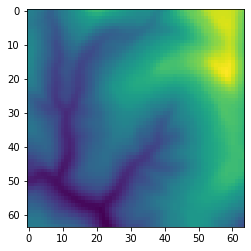

In [4]:
import matplotlib.pyplot as plt

dataset = ImagesDataset('./data')
plt.imshow(dataset[400].view(64, 64))
plt.show()

In [5]:
dataloader = DataLoader(dataset, batch_size=50, shuffle=True)

In [149]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder specification
        self.enc_cnn_1 = nn.Conv2d(1, 16, 5, padding=2)
        self.enc_cnn_2 = nn.Conv2d(16, 32, 5, padding=2)
        self.enc_linear_1 = nn.Linear(8192, 512)
        self.enc_linear_2 = nn.Linear(512, 16)
        
        # Decoder specification
        self.dec_linear_1 = nn.Linear(16, 512)
        self.dec_linear_2 = nn.Linear(512, 8192)
        self.dec_cnn_1 = nn.ConvTranspose2d(32, 16, 5, stride=4, padding=1)
        self.dec_cnn_2 = nn.ConvTranspose2d(16, 1, 2, stride=1)
        
    def encode(self, data):
        code = self.enc_cnn_1(data)
        code = F.relu(F.max_pool2d(code, 2))
        
        code = self.enc_cnn_2(code)
        code = F.relu(F.max_pool2d(code, 2))
        
        code = code.view(data.size(0), -1)
        code = F.relu(self.enc_linear_1(code))
        code = self.enc_linear_2(code)
        return code
    
    def decode(self, code):
        out = F.relu(self.dec_linear_1(code))
        out = F.relu(self.dec_linear_2(out))
        
        out = out.view(-1, 32, 16, 16)
        out = F.relu(self.dec_cnn_1(out))
        out = self.dec_cnn_2(out)
        return out
        
    def forward(self, data):
        code = self.encode(data)
        out = self.decode(code)
        return out

In [150]:
net = Autoencoder().cuda()

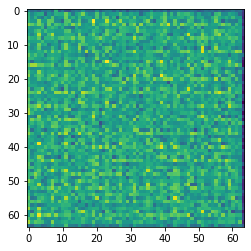

In [151]:
x = dataset[400].cuda()
output = net(x.view(1, 1, 64, 64))
plt.imshow(output.view(64, 64).cpu().detach().numpy())
plt.show()

In [180]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs):
    for data in dataloader:
        net.zero_grad()
        x = data.cuda()
        output = net(x)
        loss = nn.MSELoss()(output, x)
        loss.backward()
        optimizer.step()
    print(loss)

tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward>)


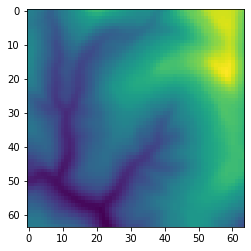

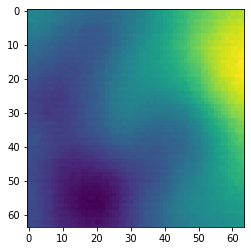

In [185]:
img = dataset[400]
x = img.cuda()
plt.imshow(img.view(64, 64))
plt.show()
output = net(x.view(-1, 1, 64, 64))
plt.imshow(output.view(64, 64).cpu().detach().numpy())
plt.show()

In [1446]:
#torch.save(net.state_dict(), './simple_autoencoder_save')

In [29]:
net.load_state_dict(torch.load('./simple_autoencoder_save'))

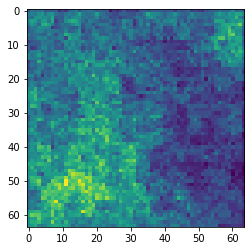

In [157]:
code = torch.tensor([-33.8204, -40.3922, -40.5138, -55.0965, -30.4725, -41.1640, -40.7616,
         -53.8898, -30.4301, -33.6328, -30.7710, -43.8495, -60, -28.5544,
         -33.2894, -43.3988]).cuda()
output = net.decode(code)
plt.imshow(output.view(64, 64).cpu().detach().numpy())
plt.show()